In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib

import findatree.io as io
import findatree.visualize as visual
import findatree.segmentation as segment
import findatree.object_properties as obj_props

importlib.reload(segment)

plt.style.use(r"C:\Repos\findatree\own.mplstyle")

### Define paths to rasters

In [29]:
importlib.reload(io)
dir_names=[]
dir_names.extend([r'C:\Data\lwf\DSM_2021'])
dir_names.extend([r'C:\Data\lwf\DTM'])
dir_names.extend([r'C:\Data\lwf\Orthophotos_2021'])

file_names=[]
# file_names.extend(['Tnr_12702_D-20210713_DSM.tif'])
# file_names.extend(['tnr_12702_dtm.tif'])
# file_names.extend(['Tnr_12702_2021_Ortho.tif'])

# file_names.extend(['Tnr_11044_D-20210707_DSM.tif'])
# file_names.extend(['tnr_11044_dtm.tif'])
# file_names.extend(['Tnr_11044_2021_Ortho.tif'])

# file_names.extend(['Tnr_11626_D-20210719_DSM.tif'])
# file_names.extend(['tnr_11626_dtm.tif'])
# file_names.extend(['Tnr_11626_2021_Ortho.tif'])

file_names.extend(['Tnr_11090_D-20210719_DSM.tif'])
file_names.extend(['tnr_11090_dtm.tif'])
file_names.extend(['Tnr_11090_2021_Ortho.tif'])

paths=[os.path.join(dir_names[i],file_name) for i, file_name in enumerate(file_names)]

# io.print_raster_info(paths)

### Reproject all rasters to same area & resolution

In [30]:
importlib.reload(io)

# Set final resolution of all rasters
resolution = 0.2

# Reproject all rasters
bands, mask, A, bound = io.reproject_all_intersect(paths, resolution=resolution)

C:\Users\flori\Anaconda3\envs\findatree_v01\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Define primary and (normalized) secondary channels

In [31]:
importlib.reload(io)

# Primary raster channels 
cs_prim = {
    'dsm': bands[0][:,:,0],
    'dtm': bands[1][:,:,0],
    'blue': bands[2][:,:,0],
    'red': bands[2][:,:,1],
    'green': bands[2][:,:,2],
    're': bands[2][:,:,3],
    'nir': bands[2][:,:,4],
}

# Secondary raster channels
downscale = 0
cs, shape_in, shape_out = io.define_channels(cs_prim, downscale=downscale)

print(f"Primary channel names: {[k for k in cs_prim]}")
print(f"Secondary channel names: {[k for k in cs]}")
print(f"Pixel width: {resolution * 2**downscale:.1f} [m]")
print(f"Image shape: {shape_out} [px]")

Primary channel names: ['dsm', 'dtm', 'blue', 'red', 'green', 're', 'nir']
Secondary channel names: ['blue', 'red', 'green', 're', 'nir', 'chm', 'ndvi', 'rgb', 'h', 'l', 's']
Pixel width: 0.2 [m]
Image shape: (2010, 1886) [px]


### Segmentation -> Objects
#### (1) Segmentation
1. Local gaussian thresholding -> mask
2. Marker based watershed with markers generated by local peaks in distance transformation of mask

In [32]:
importlib.reload(segment)

thresh_dict={
    'downscale': 1,
    'width':15,
    'blur':True,
}
water_dict={
    'downscale': 0,
    'peak_dist': 1.2,
}

labels, bounds, mask_seed, mask_global, thresh_dict, water_dict = segment.main(
    cs_prim,
    resolution,
    thresh_dict,
    water_dict,
)

Thresholding params.:
{'downscale': 1, 'width': 15, 'blur': True, 'channel': 'l', 'shape': (1005, 943), 'px_width': 0.4}
Watershed params.:
{'downscale': 0, 'peak_dist': 1.2, 'channel': 'l', 'shape': (2010, 1886), 'px_width': 0.2}

    ... (thresholding) Gaussian thresholding kernel width: 15.0 [m] = 39 [px]
    ... (watershed) Removing holes of area: 0.20 [m**2] = 5 [px]
    ... (watershed) Peaks in distance transform separated by minimum distance: 1.2 [m] = 5 [px]


#### (2) Plot segmentation results

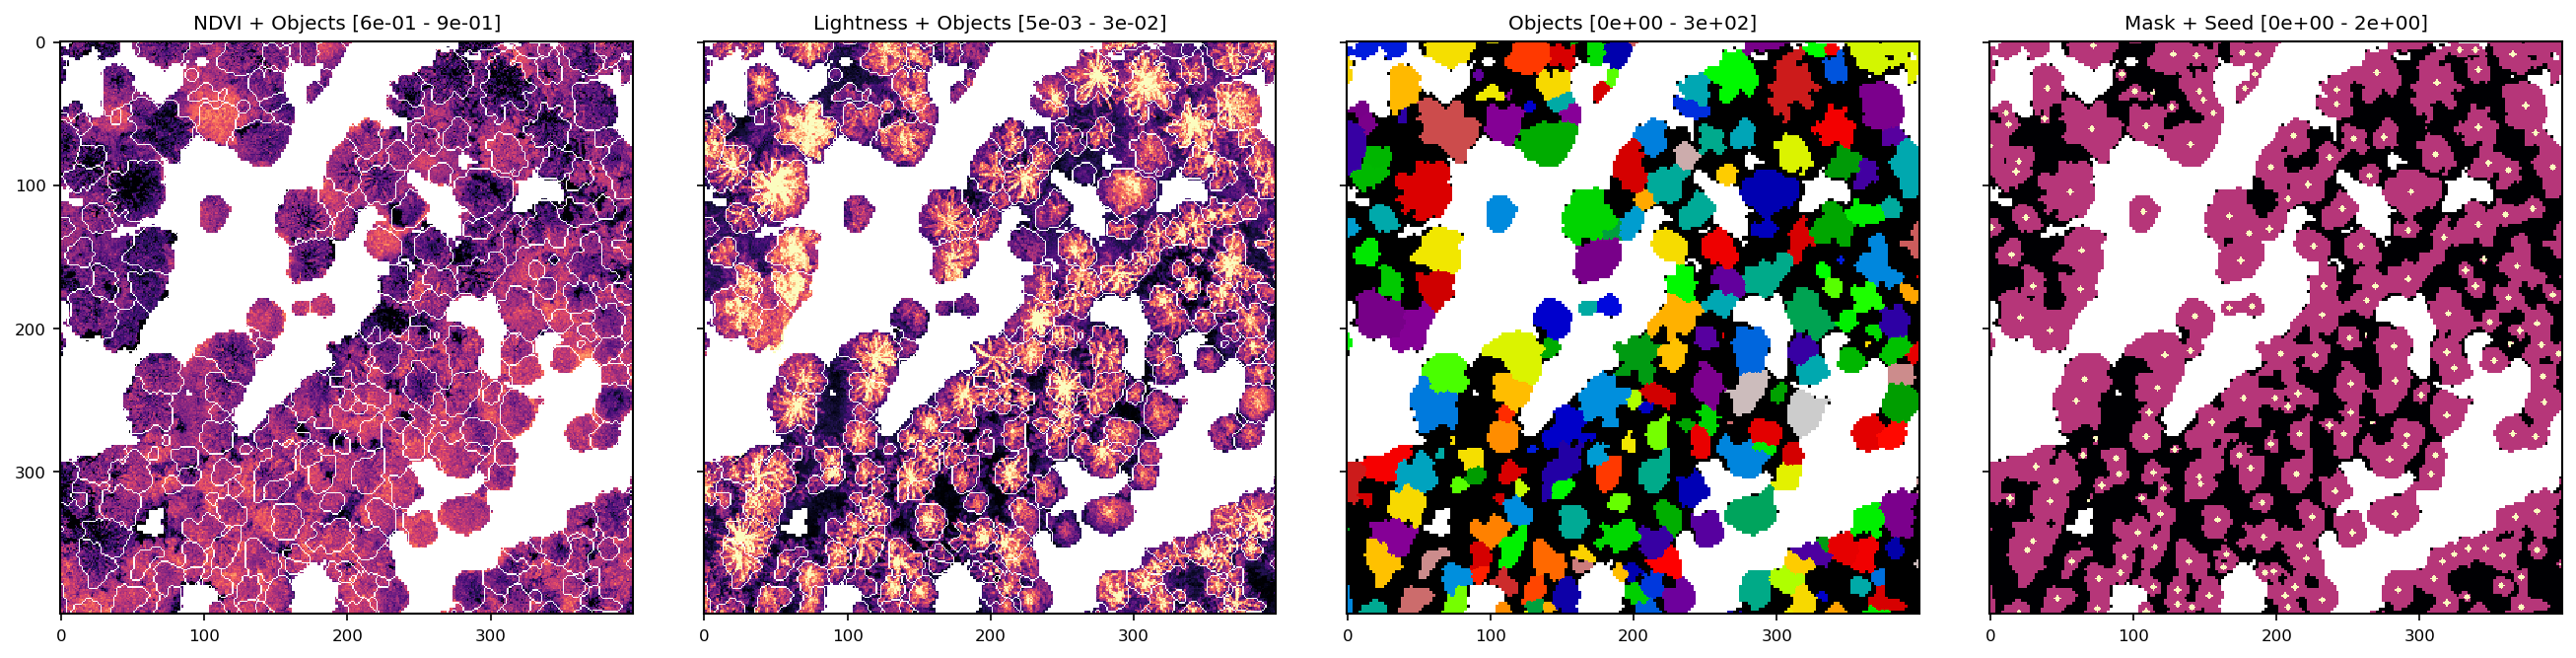

In [33]:
segment_l = cs['l'].copy()
segment_l[bounds == 1] = np.nan

segment_ndvi = cs['ndvi'].copy()
segment_ndvi[bounds == 1] = np.nan

channels = [
    segment_ndvi, segment_l, labels, mask_seed,
]
use_random_cmap = [
    False, False, True, False, 
    ]
channels_names = [
    'NDVI + Objects','Lightness + Objects', 'Objects', 'Mask + Seed',
]
contrasts = [
    (0.6, 0.9), (5e-3, 3.3e-2), None, None,
]

# ROI
width = 200
x_center = 600
y_center = 600
xylim = [(x_center, width), (y_center, width)]

f, axs = visual.show_channels(
    channels,
    xylim=xylim,
    mask=mask_global,
    contrasts=contrasts,
    use_random_cmap=use_random_cmap,
    channel_names=channels_names,
    zoom=1.5,
    # n_cols_rows=(3,2),
)

# plt.savefig(r'C:\Users\flori\Desktop\plots\220405\220405_tnr12702.pdf', transparent=True)
# plt.savefig(r'C:\Users\flori\Desktop\plots\220405\220405_tnr11044.pdf', transparent=True)
# plt.savefig(r'C:\Users\flori\Desktop\plots\220405\220405_tnr11626.pdf', transparent=True)
# plt.savefig(r'C:\Users\flori\Desktop\plots\220405\220405_tnr11090.pdf', transparent=True)

### Object properties

In [34]:
# import skimage.measure as measure
# props = measure.regionprops(labels, cs['l'])
# keys = [key for key in props[0]]

# props_table = measure.regionprops_table(
#     labels,
#     cs['ndvi'],
#     properties=keys,
#     )

# props_df = pd.DataFrame(props_table)

In [35]:
# bins = np.linspace(0.5,1, 80)

# f, axs = plt.subplots(ncols=2, figsize=[8,3])

# ax = axs[0]
# _ = ax.hist(
#     props_df['intensity_mean'],
#     bins=bins,
#     histtype='step',
#     label='Mean NDVI'
#     )
# ax.legend()

# ax = axs[1]
# _ = ax.scatter(
#     props_df['intensity_mean'],
#     props_df['equivalent_diameter_area'] * resolution,
#     alpha=0.05,
#     )
# _ = ax.set_xlabel('Mean NDVI')
# _ = ax.set_ylabel(r'Equiv. diameter [$m$]')

In [36]:
# i = np.random.randint(0,len(props))
# # i = 2593
# print(i)
# prop = props[i]

# mask = prop['image_filled']
# slice = prop['slice']

# l = prop['image_intensity']
# ndvi = cs['ndvi'][slice] * mask

# channels = [mask, l, ndvi]
# contrasts = [(0,1), (1e-3, 3.5e-2), (0.5,1)]
# channel_names = ['Mask', 'L' , 'NDVI']


# f, axs = visual.show_channels(
#     channels,
#     contrasts=contrasts,
#     channel_names=channel_names,
#     zoom=0.8,
# )

# y,x = prop['centroid_local']
# yw,xw = prop['centroid_weighted_local']
# _ = axs[1].scatter(x, y, s=20, marker='o', fc='w', ec='k')
# _ = axs[1].scatter(xw, yw, s=40, marker='s', fc='none', ec='k')
